In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn import utils
import joblib
import matplotlib.pyplot as plt 

In [30]:
# 업비트 데이터 수집하기 1일봉으로 365개 1년 데이터 수집
from google.colab import files
df=pd.read_excel('df.xlsx')

In [32]:
#test & train 분할하기
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['open', 'high', 'low', 'close', 'volume']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])
scaled

array([[0.        , 0.        , 0.        , 0.        , 0.11862466],
       [0.01127525, 0.04064659, 0.01508845, 0.0415615 , 0.15316289],
       [0.0523689 , 0.08170813, 0.04888881, 0.04047457, 0.36544834],
       ...,
       [0.61057578, 0.60439481, 0.62126505, 0.60114957, 0.07294777],
       [0.60576695, 0.6251962 , 0.61225286, 0.63314972, 0.08739229],
       [0.63729758, 0.63997186, 0.65183217, 0.64068459, 0.        ]])

In [33]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [36]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=0, shuffle=False)

In [37]:
x_train.shape, y_train.shape

((292, 4), (292,))

In [38]:
x_test.shape, y_test.shape

((73, 4), (73,))

In [39]:
x_train

,open,high,low,volume
0,0.000000,0.000000,0.000000,0.118625
1,0.011275,0.040647,0.015088,0.153163
2,0.052369,0.081708,0.048889,0.365448
3,0.051804,0.059824,0.055671,0.122669
4,0.067688,0.058616,0.053088,0.104593
...,...,...,...,...
287,0.710359,0.738404,0.724320,0.127434
288,0.718556,0.729943,0.733759,0.057796
289,0.738702,0.753252,0.746600,0.068513
290,0.752254,0.799744,0.768842,0.148131


In [40]:
# TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성
import tensorflow as tf

In [41]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [42]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [43]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [44]:
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [54]:
# 모델!!!!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [55]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [56]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습 중단
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [57]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
      6/Unknown - 3s 11ms/step - loss: 0.1090 - mse: 0.2179
Epoch 00001: val_loss improved from inf to 0.14296, saving model to tmp/ckeckpointer.ckpt
9/9 [==============================] - 3s 93ms/step - loss: 0.1012 - mse: 0.2025 - val_loss: 0.1430 - val_mse: 0.2859
Epoch 2/50
6/9 [===================>..........] - ETA: 0s - loss: 0.0535 - mse: 0.1069
Epoch 00002: val_loss improved from 0.14296 to 0.05325, saving model to tmp/ckeckpointer.ckpt
9/9 [==============================] - 0s 20ms/step - loss: 0.0472 - mse: 0.0944 - val_loss: 0.0533 - val_mse: 0.1065
Epoch 3/50
5/9 [===============>..............] - ETA: 0s - loss: 0.0192 - mse: 0.0384
Epoch 00003: val_loss improved from 0.05325 to 0.00939, saving model to tmp/ckeckpointer.ckpt
9/9 [==============================] - 0s 19ms/step - loss: 0.0147 - mse: 0.0294 - val_loss: 0.0094 - val_mse: 0.0188
Epoch 4/50
5/9 [===============>..............] - ETA: 0s - loss: 0.0076 - mse: 0.0152
Epoch 00004: val_loss improved from 

In [58]:
# 저장한 데이터 로드
model.load_weights(filename)

In [60]:
#test 데이터로 예측 진행
pred = model.predict(test_data)
pred.shape

(53, 1)

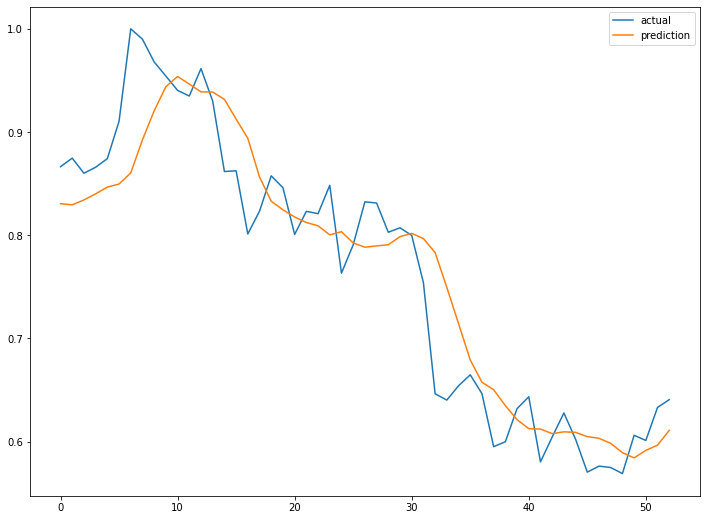

In [61]:
# 자! 그럼 이제 예측한 데이터를 시각화해보장 >_<
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()